Loading libraries needed

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt; plt.rcdefaults()


An example of a series of walks: Twitter => VRT => Facebook => Facebook => Twitter => Google

An example of a walk: Twitter => VRT 

In [2]:
# function count the walks from this app to that app in the list_walks
def count_walks(this, that, list_walks):
    r = 0
    for walks in list_walks:
        n = len(walks)
        for i in range(n-1):           
            if (walks[i] == this) & (walks[i+1] == that):
                r +=1
    return r


# function to calculate the probability for the next app
def appwalk(app, s2app_list, list_walks):

    total_walks = sum(count_walks(app, p, list_walks) for p in s2app_list)

    list_per = [round(count_walks(app, p, list_walks)/total_walks, 2) for p in s2app_list ]

    percent_list = pd.DataFrame(
    {'next_app': s2app_list,
     'percent': list_per
     })
    return percent_list.sort_values('percent',ascending=False)


Create a class to explore dataset for each user id

In [3]:
class explore:
    
    
    def __init__(self, data):
              
        # set data as an object property
        self._data = data
        
        ds = data.groupby('ids').count().sort_values('newid', ascending=False)
        ds = ds.reset_index()
        ds2 = list(ds.loc[ds['newid']>1,'ids'])

        data2s = data.loc[data.ids.isin(ds2)]
        
        list_walks = [] # keep the list of walks 
        for s in ds2:

            edata = data2s.loc[data2s['ids'] == s,]
            list_walks.append(list(edata['app_name']))
         
        self._ids2 = ds2
        self._data2s = data2s
        
        self._popular = self.pop()
        self._apps = list(data2s.app_name.unique())
        
        self.list_walks = list_walks
        
        ########### Creating data for the graph        

        datafr = pd.DataFrame(self._popular)
        datafr.columns = ['next_app'] # prepare empty dataframe with the same col of app names

        for app in self._popular:

            total_walks = sum(count_walks(app, p, self.list_walks) for p in self._popular)
            if total_walks == 0:
                pass
            else:
                d = appwalk(app, self._popular, self.list_walks)

                d.columns= ['next_app', app]
                datafr = pd.merge(datafr, d, on='next_app')

        datafr.reset_index(level = 0, inplace = True)

        datafrt = datafr.T
        datafrt.columns = datafrt.iloc[1]
        datafrt = datafrt.iloc[2:,:]
        datafrt.reset_index(level = 0, inplace = True)
        
        data_np= np.array(datafrt.iloc[:, 1:].values)
        data_np= data_np.astype('float64') 
        
        self.data_np = data_np
        self.datafr = datafr
        
    
    def factor(self):
        f = 1
        for i in range(2, len(self.datafr.columns)):
            f *= max(self.datafr.iloc[:, i])
            
        
        return round(f ** (1/len(self._popular)), 2)
    
    def apps(self):
        return self._apps
    
    
    def pop(self):
        d = self._data.groupby('app_name').count().sort_values('newid', ascending=False)
        d = d.reset_index()      
        n = min(len(self._data.app_name.unique()), 10) # 10 or less popular apps
        return list(d.iloc[0:n,0])

    
    def walks(self):
        return  self.list_walks
    
    
    def gateway(self):
        
        
        v, h = self._popular, self._popular

        fig, ax = plt.subplots()
        im = ax.imshow(self.data_np)

        # We want to show all ticks...
        ax.set_xticks(np.arange(len(h)))
        ax.set_yticks(np.arange(len(v)))

        # ... and label them with the respective list entries
        ax.set_xticklabels(h)
        ax.set_yticklabels(v)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")

        try: 
            # Loop over data dimensions and create text annotations.
            for i in range(len(v)):
                for j in range(len(h)):

                    text = ax.text(j, i, self.data_np[i, j], ha="center", va="center", color="w")


            ax.set_title("Probability for the next app")
            fig.tight_layout()
        
        except IndexError: # ignore the index error, still export the graph
            pass
        plt.show()
    


## Apply Class 

### Load data

In [4]:
dat1 = pd.read_csv('dat6.csv')


In [5]:
data1 = dat1.loc[:, ['newid', 'ids','app_name','startTimeMillis']]

In [150]:
data_i = data1.loc[data1['newid']== 8,:]
datax = explore(data_i)
datax.factor()

0.48

### Calculate and Extract the proposed factors then Save into excel file

In [151]:
import time
start = time.time()

factor_list = []
for i in range(1,2010):
    data_i = data1.loc[data1['newid']== i,:]
    datax = explore(data_i)
    factor_list.append(datax.factor())

end = time.time()
print(end - start)

1126.1175091266632


In [153]:
len(factor_list)

2009

In [157]:
factor = pd.DataFrame({'newid': range(1,2010), 'factor': factor_list})

In [158]:
factor.to_excel('factor.xlsx')

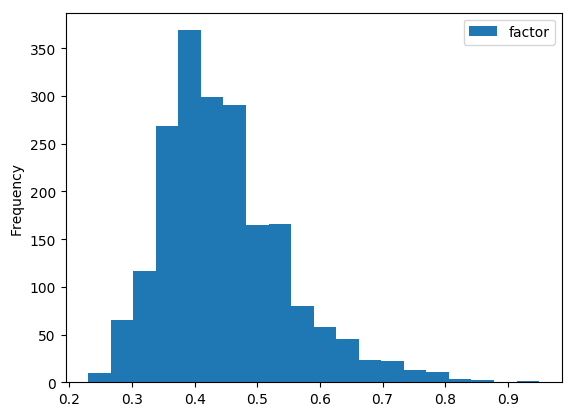

In [195]:
f=factor.set_index('newid')
f.plot.hist(bins=20)
plt.show()

In [167]:
min(factor['factor'])

0.23

In [168]:
max(factor['factor'])

0.95

In [172]:
np.mean(factor['factor'])

0.4483275261324047

In [173]:
np.median(factor['factor'])

0.42999999999999999

In [178]:
factor = factor.sort_values('factor')

### Explore the users having lowest and highest factors

In [184]:
bottom_id = list(factor.head(5).newid) # keep the IDs having lowest factors

In [185]:
top_id = list(factor.tail(5).newid) # keep the IDs having highest factors

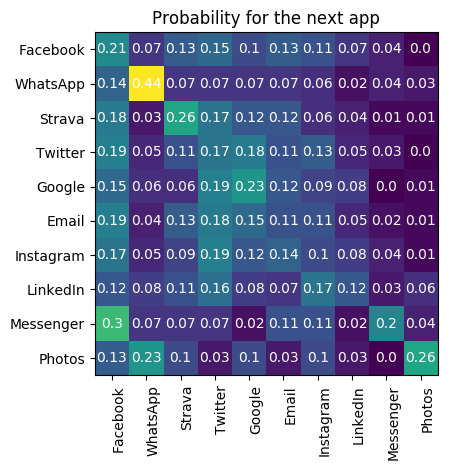

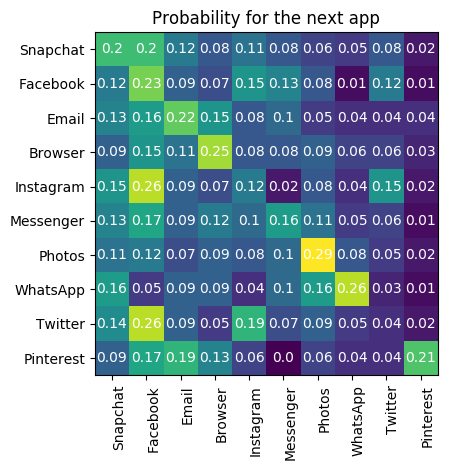

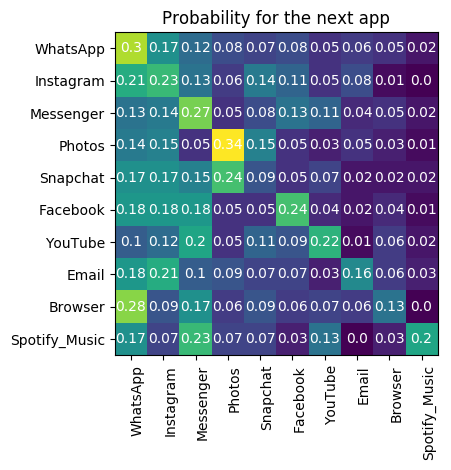

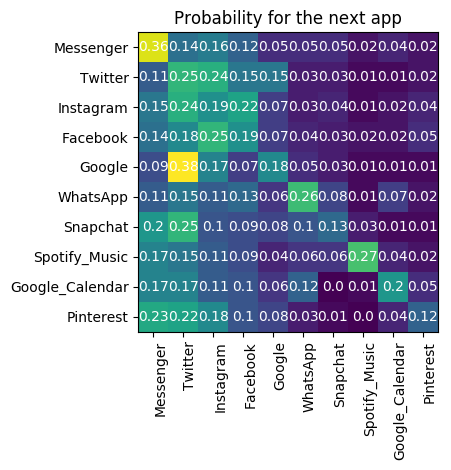

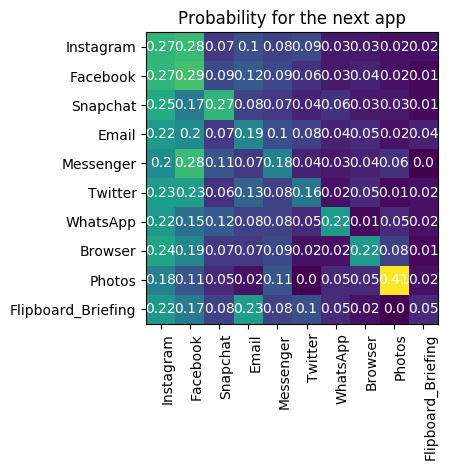

In [186]:
for i in bottom_id:
    data_i = data1.loc[data1['newid']== i,:]
    data = explore(data_i)
    data.gateway()

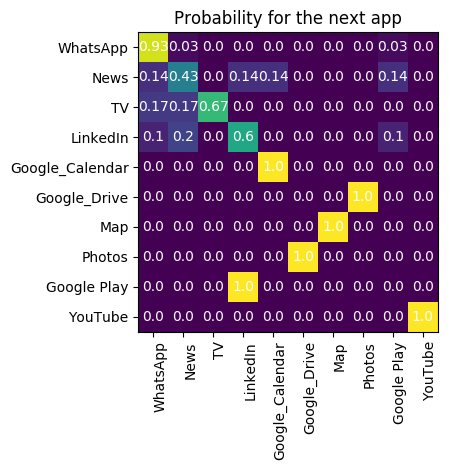

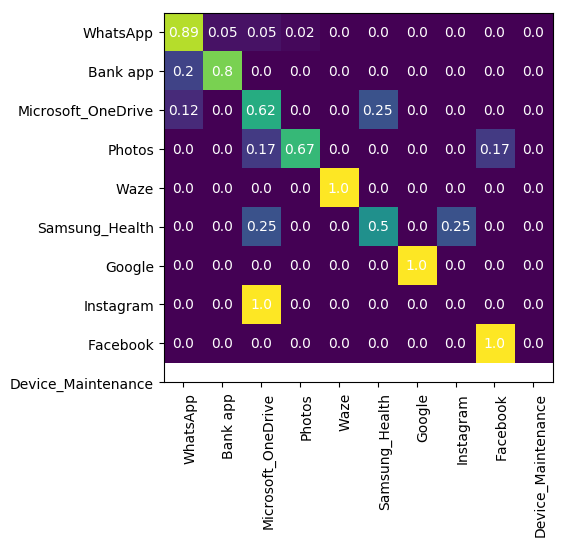

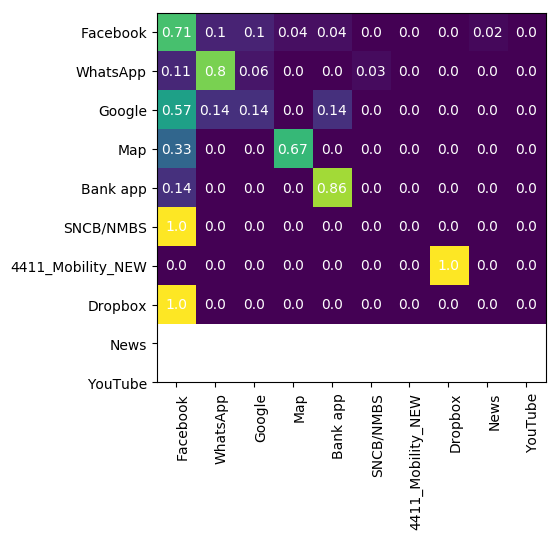

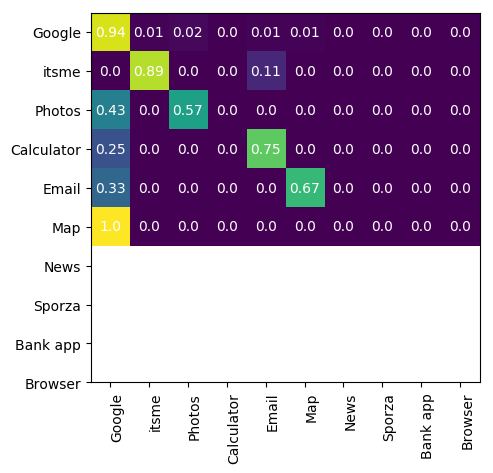

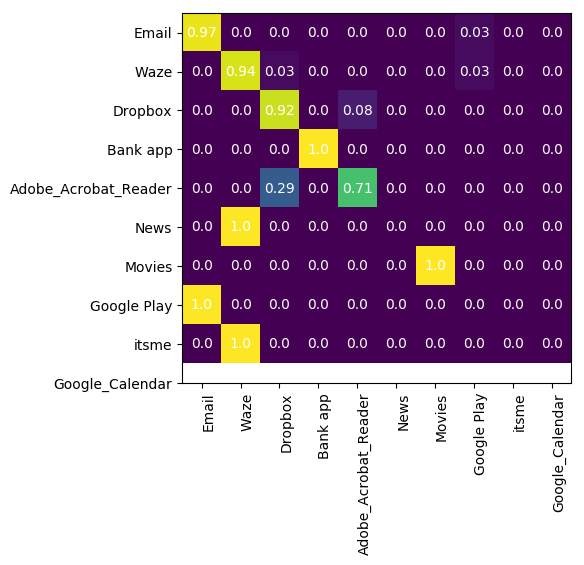

In [207]:
for i in top_id:
    data_i = data1.loc[data1['newid']== i,:]
    data = explore(data_i)
    data.gateway()

In [188]:
top_id

[463, 969, 1827, 111, 1798]

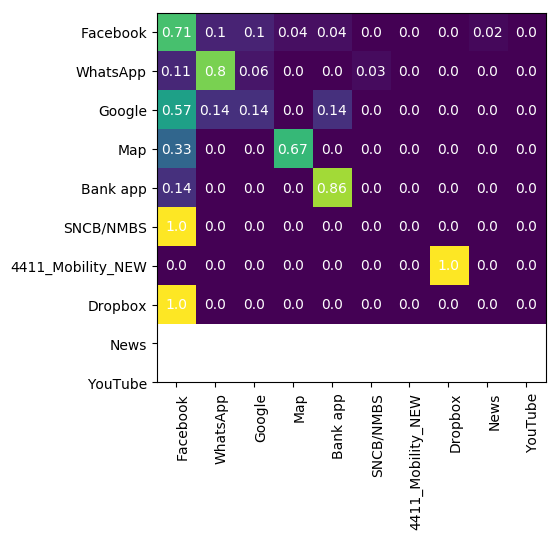

In [202]:
i= 1827
data_i = data1.loc[data1['newid']== i,:]
data = explore(data_i)
try:
    data.gateway()
except IndexError:
    pass

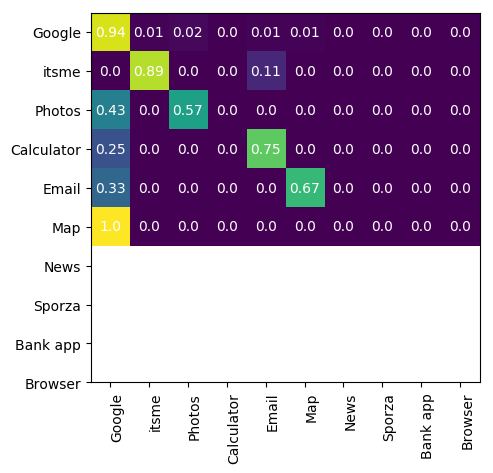

In [204]:
i= 111
data_i = data1.loc[data1['newid']== i,:]
data = explore(data_i)
data.gateway()

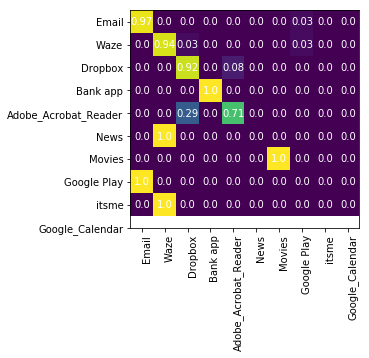

In [7]:
i = 1798
data_i = data1.loc[data1['newid']== i,:]
data = explore(data_i)
data.gateway()

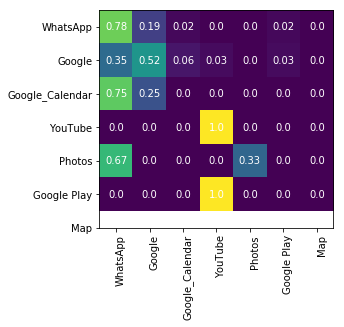

In [10]:
i = 1961
data_i = data1.loc[data1['newid']== i,:]
data = explore(data_i)
data.gateway()

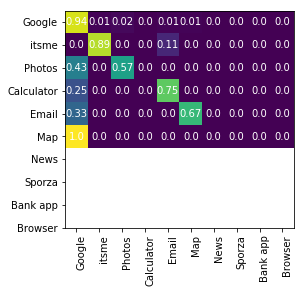

In [8]:
i = 111
data_i = data1.loc[data1['newid']== i,:]
data = explore(data_i)
data.gateway()

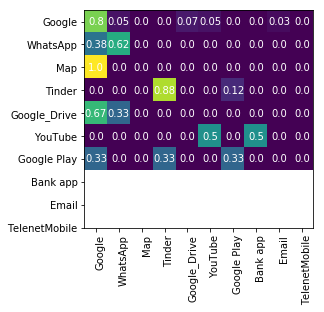

In [9]:
i = 1554
data_i = data1.loc[data1['newid']== i,:]
data = explore(data_i)
data.gateway()

### User 1

In [98]:
i = 1 #  i in 1,2 ...2009
data_i = data1.loc[data1['newid']== i,:]

In [110]:
data = explore(data_i)

In [111]:
data.factor()

0.4273069999203702

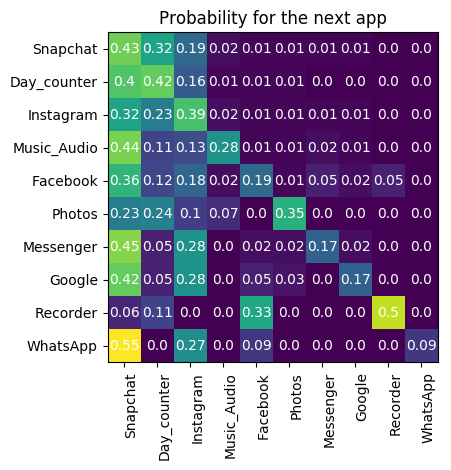

In [104]:
data.gateway()

In [33]:
data.apps()

['Facebook',
 'Snapchat',
 'Instagram',
 'Messenger',
 'WhatsApp',
 'Day_counter',
 'Photos',
 'Google',
 'Music_Audio',
 'Recorder',
 'Flipboard_Briefing',
 'My_Orange_BE',
 'Photomath',
 'Sandbox',
 'YouTube',
 'Calculator',
 'Google Play',
 'Game',
 'Device_Maintenance']

In [34]:
data.pop()

['Snapchat',
 'Day_counter',
 'Instagram',
 'Music_Audio',
 'Facebook',
 'Photos',
 'Messenger',
 'Google',
 'Recorder',
 'WhatsApp']

### User 2

In [17]:
i = 2 #  i in 1,2 ...2009
data_2 = data1.loc[data1['newid']== i,:]

In [71]:
data2 = explore(data_2)

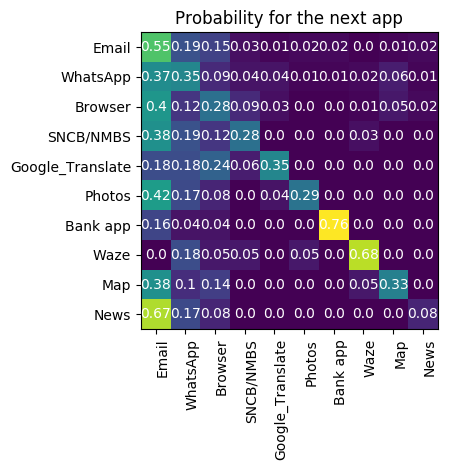

In [72]:
data2.gateway()

In [89]:
# data2.walks()

In [74]:
data2.apps()

['Browser',
 'Email',
 'WhatsApp',
 'Google_Drive',
 'Radio',
 'Google',
 'Photos',
 'LinkedIn',
 'Wine',
 'Google_Translate',
 'SNCB/NMBS',
 'Calculator',
 'News',
 'Waze',
 'MyProximus',
 'Booking',
 'Map',
 'YouTube',
 'Microsoft_Office',
 'Sporza_Voetbal',
 'Bank app',
 'Dropbox',
 'Jive Daily',
 'Skype',
 'itsme',
 'Station finder',
 'Spencer_for_Proximus',
 'Google Play',
 'QR',
 'TripAdvisor',
 'Twitter',
 'mobileDNA',
 'Device_Maintenance',
 'TV']

In [75]:
data2.pop()

['Email',
 'WhatsApp',
 'Browser',
 'SNCB/NMBS',
 'Google_Translate',
 'Photos',
 'Bank app',
 'Waze',
 'Map',
 'News']

### user 3

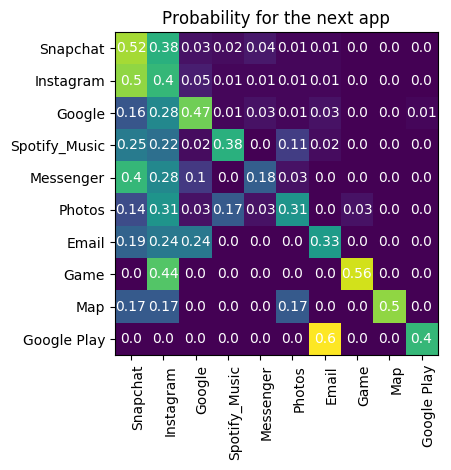

In [76]:
i = 3 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


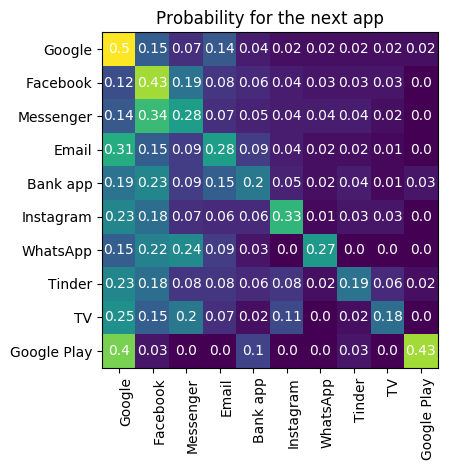

In [77]:
i = 4 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


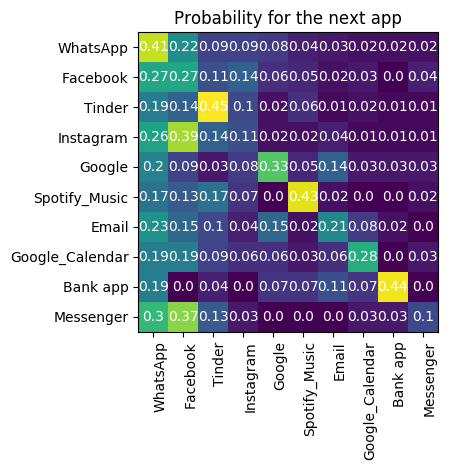

In [78]:
i = 5 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


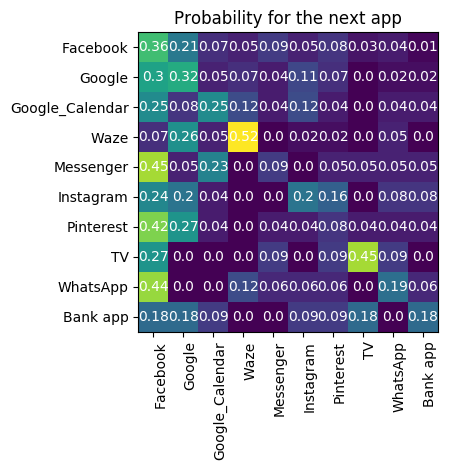

In [79]:
i = 6 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


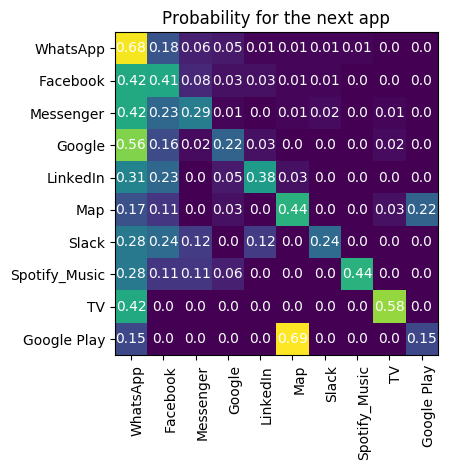

In [80]:
i = 7 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


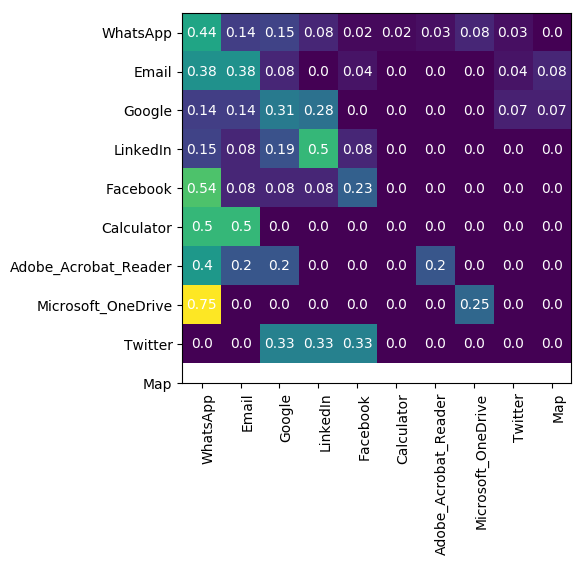

In [208]:
i = 8 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax8 = explore(data)
datax8.gateway()


In [91]:
datax8.pop()

['WhatsApp',
 'Email',
 'Google',
 'LinkedIn',
 'Facebook',
 'Calculator',
 'Adobe_Acrobat_Reader',
 'Microsoft_OneDrive',
 'Twitter',
 'Map']

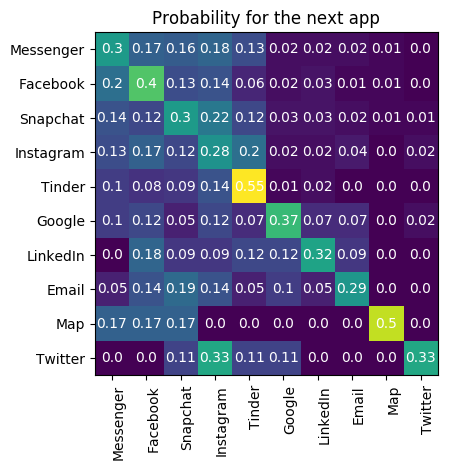

In [82]:
i = 9 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


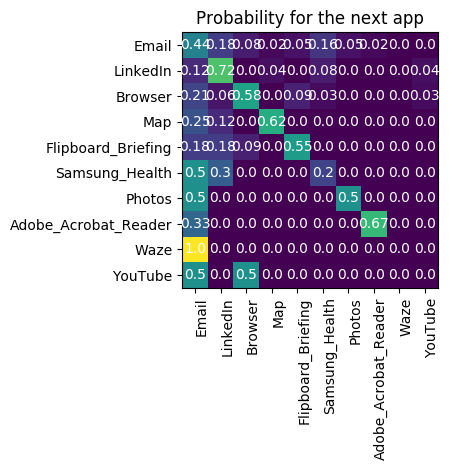

In [83]:
i = 10 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


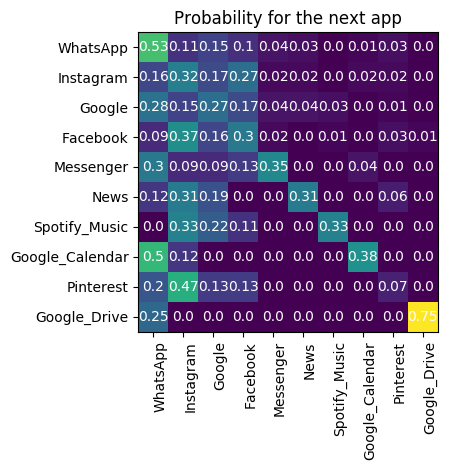

In [84]:
i = 11 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


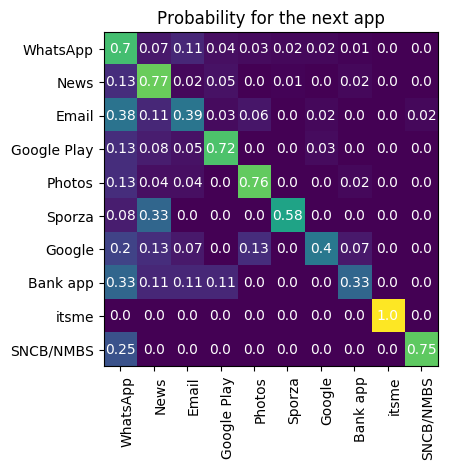

In [85]:
i = 12 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


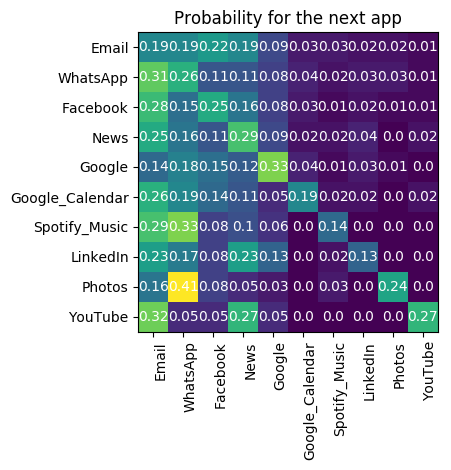

In [86]:
i = 13 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


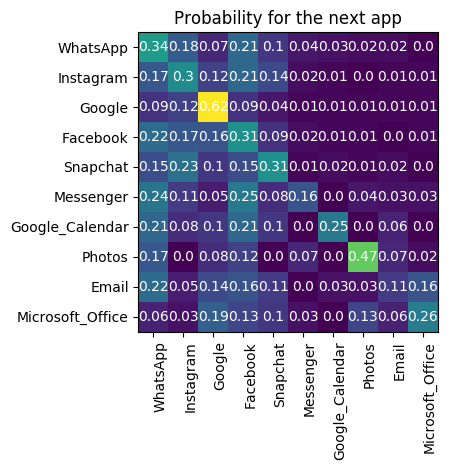

In [87]:
i = 14 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()


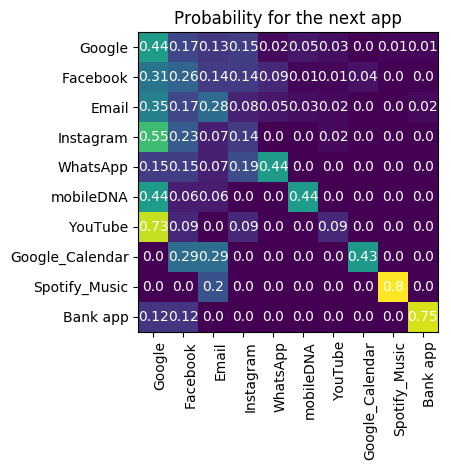

In [88]:
i = 15 #  i in 1,2 ...2009
data = data1.loc[data1['newid']== i,:]
datax = explore(data)
datax.gateway()
